In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os

enable google drive access

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
CHECKPOINT_DIR = '/content/gdrive/My Drive/Colab/checkpoints/'

The following function creates as many time series as requested (via the batch_size argument), each of length n_steps, and there is just one value per time step in each series (i.e., all series are univariate). The function returns a NumPy array of shape [batch size, time steps, 1], where each series is the sum of two sine waves of fixed amplitudes but random frequencies and phases, plus a bit of noise.

In [12]:

def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [ ]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1) # data

<h1>Goal</h1>
<p>Given a time series with `n_steps` timesteps, predict the value of the next timestep.</p>

Now let’s create a training set, a validation set, and a test set using this function. <br>
X_train contains 7,000 time series (i.e., its shape is [7000, 50, 1]), while X_valid contains 2,000 (from the 7,000th time series to the 8,999th) and X_test contains 1,000 (from the 9,000th to the 9,999th). Since we want to forecast a single value for each series, the targets are column vectors (e.g., y_train has a shape of [7000, 1]).

In [ ]:
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

<h1>Baseline Metrics</h1>

In [ ]:
lin_regression = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[n_steps, 1]),
    keras.layers.Dense(1) # 1 means output dimension is 1
])

lin_regression.compile(optimizer='adam',
              loss=keras.losses.MeanSquaredError())


In [ ]:
lin_regression.fit(X_train, y_train, epochs=20)

Epoch 1/20
219/219 [==============================] - 1s 1ms/step - loss: 0.2737
Epoch 2/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0780
Epoch 3/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0401
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0239
Epoch 5/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0166
Epoch 6/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0131
Epoch 7/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0113
Epoch 8/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0100
Epoch 9/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0090
Epoch 10/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0081
Epoch 11/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0074
Epoch 12/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0067
Epoch 13/20
219/219 [====

In [ ]:
lin_regression.evaluate(X_test, y_test, verbose=2)

32/32 - 0s - loss: 0.0040 - 136ms/epoch - 4ms/step


0.003978326916694641

<h1>SimpleRnn</h1>

In [ ]:
simp_rnn = keras.models.Sequential([
  keras.layers.SimpleRNN(1) # 1 means the output of each RNN cell has dimension 1
])

simp_rnn.compile(optimizer='adam',
              loss=keras.losses.MeanSquaredError())

In [ ]:
# inputs of simp_rnn have shape (batch, num_of_timesteps, feature)
minibatch = X_train[:32] # has shape (32, 50, 1)
simp_rnn(minibatch).shape
# the shape is TensorShape([32, 1]). 32 means minibatch size. 1 refers to the last output in the output sequence.
# by default, only the last output instead of the whole output sequence is returned.

TensorShape([32, 1])

In [ ]:
# sim_rnn_1 is when return_sequences=True and return_state=True
simp_rnn_1 = keras.layers.SimpleRNN(1, return_sequences=True, return_state=True)
output_sequence, last_state = simp_rnn_1(minibatch)

In [ ]:
print(output_sequence.shape)
print(last_state.shape)

(32, 50, 1)
(32, 1)


In [ ]:
simp_rnn.fit(X_train, y_train, epochs=20)

Epoch 1/20
219/219 [==============================] - 2s 7ms/step - loss: 0.2123
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.1018
Epoch 3/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0741
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0609
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0514
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0444
Epoch 7/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0390
Epoch 8/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0347
Epoch 9/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0312
Epoch 10/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0284
Epoch 11/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0260
Epoch 12/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0239
Epoch 13/20
219/219 [====

In [ ]:
simp_rnn.evaluate(X_test, y_test, verbose=2) # worse than baseline

32/32 - 0s - loss: 0.0143 - 236ms/epoch - 7ms/step


0.014336829073727131

In [ ]:
# simp_rnn_10
simp_rnn_10 = keras.models.Sequential([
  keras.layers.SimpleRNN(10), # output of this layer is 10-dimensional
  keras.layers.Dense(1) # kind of like decoder
])

simp_rnn_10.compile(optimizer='adam',
              loss=keras.losses.MeanSquaredError())

In [ ]:
y, last_state = keras.layers.SimpleRNN(10, return_state=True)(minibatch)

In [ ]:
y == last_state # all true

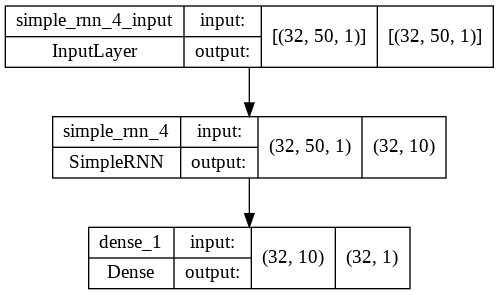

In [ ]:
keras.utils.plot_model(simp_rnn_10, show_shapes=True)

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(CHECKPOINT_DIR, 'simp_rnn_10.ckpt'), 
    verbose=1, 
    save_weights_only=True,
    save_freq = 'epoch')

simp_rnn_10.fit(X_train, y_train, epochs=20, callbacks=[cp_callback])

Epoch 1/20
211/219 [===========================>..] - ETA: 0s - loss: 0.0209
Epoch 1: saving model to /content/gdrive/My Drive/Colab/checkpoints/simp_rnn_10.ckpt
219/219 [==============================] - 4s 13ms/step - loss: 0.0204
Epoch 2/20
212/219 [============================>.] - ETA: 0s - loss: 0.0066
Epoch 2: saving model to /content/gdrive/My Drive/Colab/checkpoints/simp_rnn_10.ckpt
219/219 [==============================] - 1s 4ms/step - loss: 0.0066
Epoch 3/20
212/219 [============================>.] - ETA: 0s - loss: 0.0050
Epoch 3: saving model to /content/gdrive/My Drive/Colab/checkpoints/simp_rnn_10.ckpt
219/219 [==============================] - 1s 4ms/step - loss: 0.0050
Epoch 4/20
212/219 [============================>.] - ETA: 0s - loss: 0.0043
Epoch 4: saving model to /content/gdrive/My Drive/Colab/checkpoints/simp_rnn_10.ckpt
219/219 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 5/20
218/219 [============================>.] - ETA: 0s - loss: 0

In [ ]:
simp_rnn_10.evaluate(X_test, y_test, verbose=2) # 0.00349, slightly better than baseline

32/32 - 1s - loss: 0.0034 - 577ms/epoch - 18ms/step


0.0034157922491431236

In [ ]:
i = 0 # i^th test data
X_test_i = X_test[i]
X_test_i = np.expand_dims(X_test_i, axis=0) # X_test_i.shape = (1, 50, 1)
print(simp_rnn_10.predict(X_test_i))
print(y_test[i])

[[-0.5664011]]
[-0.5037774]


let's predict the next k values of a series:

In [ ]:
k = 10

In [ ]:
series = generate_time_series(batch_size=1, n_steps=(n_steps+k))
X, y = series[:, :n_steps, :], series[:, n_steps:, :]
for step_ahead in range(k):
  y_pred_one = simp_rnn_10.predict(X[:, step_ahead:, :]) # has shape (1, 1). The first 1 means batch size
  y_pred_one = np.reshape(y_pred_one, (1, 1, 1))
  # append predicted value to X
  X = np.concatenate([X, y_pred_one], axis=1)

# the last k values of the time series X are model predictions
y_pred = X[:, n_steps:, :]

In [ ]:
y_pred_reshaped = np.reshape(y_pred, (1, k))
y_reshaped = np.reshape(y, (1, k))
mse = keras.losses.MeanSquaredError()(y_pred_reshaped, y_reshaped).numpy()
mse # 0.09156108

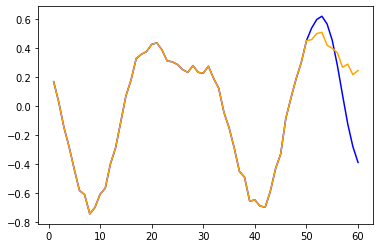

In [ ]:
X_pred_reshaped = np.reshape(X, (n_steps+k,))
X_reshaped = np.reshape(series, (n_steps+k,))

fig, ax = plt.subplots()
ax.plot(np.arange(1, n_steps+k+1), X_pred_reshaped, color='blue')
ax.plot(np.arange(1, n_steps+k+1), X_reshaped, color='orange')

# by the way, good reference:
# https://stackoverflow.com/questions/32899463/how-can-i-overlay-two-graphs-in-seaborn

<h1>Seq-to-seq</h1>

training input will be values from timestep 0 to timestep 49 <br>
training output will be values from timestep 1 to timestep 50


In [13]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1) # data

In [14]:
# note Y is capitalized here
X_train, Y_train = series[:7000, :n_steps], series[:7000, 1:n_steps+1]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, 1:n_steps+1]
X_test, Y_test = series[9000:, :n_steps], series[9000:, 1:n_steps+1]

In [15]:
Y_train.shape

(7000, 50, 1)

The advantage of sequence-to-sequence models is that the loss will contain a term for the output of the RNN at each and every time step, not just the output at the last time step. This means there will be many more error gradients flowing through the model, and they won’t have to flow only through time; they will also flow from the output of each time step. This will both stabilize and speed up training.

All outputs are needed during training, but only the output at the last time step is useful for predictions and for evaluation. So although we will rely on the MSE over all the outputs for training, we will use a custom metric for evaluation, to only compute the MSE over the output at the last time step:

In [16]:
# Y_true, Y_pred have shape (batch_size, num_of_timesteps, output_feature_dimension)
def last_time_step_mse(Y_true, Y_pred):
  return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])
  # note the shape of inputs of keras.metrics.mean_squared_error must look like
  # (batch_size, ...)


In [ ]:
seq_to_seq = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1)) # for an input at each timestep, output the predicted value at the next timestep
])
# seq_to_seq.predict(X_test) has shape (1000, 50, 1), which is the same as X_test's.

optimizer = keras.optimizers.Adam()
seq_to_seq.compile(optimizer=optimizer,
              loss=keras.losses.MeanSquaredError(), metrics=[last_time_step_mse])

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(CHECKPOINT_DIR, 'seq_to_seq.ckpt'), 
    verbose=1, 
    save_weights_only=True,
    save_freq = 'epoch')

seq_to_seq.fit(X_train, Y_train, epochs=20, callbacks=[cp_callback])

In [ ]:
seq_to_seq.evaluate(X_test, Y_test) # last_time_step_mse: 0.0027, better than simp_rnn_10's 0.0034

32/32 [==============================] - 1s 7ms/step - loss: 0.0039 - last_time_step_mse: 0.0028


[0.0038917907513678074, 0.0027930832002311945]

In [ ]:
# I should have used X_valid, Y_valid
seq_to_seq.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0039 - last_time_step_mse: 0.0028


[0.0038681102450937033, 0.0028096591122448444]

In [ ]:
# try keras.layers.Dense(10) instead of Dense(1) and use averaging -- ensemble

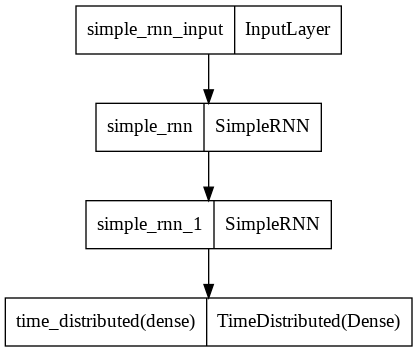

In [ ]:
keras.utils.plot_model(seq_to_seq)

Given a test time series, plot it with the seq_to_seq-predicted shifted time series to see how close the two are.

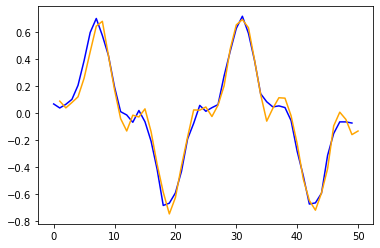

In [ ]:
i = 1
X_test_i = X_test[i:(i+1)] # has shape (1, 50, 1)
Y_pred = seq_to_seq.predict(X_test_i)

X_test_i_reshaped = np.reshape(X_test_i, (n_steps,))
Y_pred_reshaped = np.reshape(Y_pred, (n_steps,))
# we do the following because Y_pred predicts the *shift* of X_test_i
X_test_i_reshaped = np.concatenate((X_test_i_reshaped, [np.nan]))
Y_pred_reshaped = np.concatenate(([np.nan], Y_pred_reshaped))

fig, ax = plt.subplots()
ax.plot(np.arange(0, n_steps+1), X_test_i_reshaped, color='blue')
ax.plot(np.arange(0, n_steps+1), Y_pred_reshaped, color='orange')

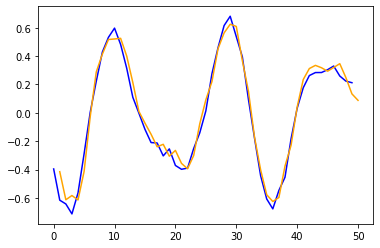

In [ ]:
i = 2
X_test_i = X_test[i:(i+1)] # has shape (1, 50, 1)
Y_pred = seq_to_seq.predict(X_test_i)

X_test_i_reshaped = np.reshape(X_test_i, (n_steps,))
Y_pred_reshaped = np.reshape(Y_pred, (n_steps,))
X_test_i_reshaped = np.concatenate((X_test_i_reshaped, [np.nan]))
Y_pred_reshaped = np.concatenate(([np.nan], Y_pred_reshaped))

fig, ax = plt.subplots()
ax.plot(np.arange(0, n_steps+1), X_test_i_reshaped, color='blue')
ax.plot(np.arange(0, n_steps+1), Y_pred_reshaped, color='orange')

use seq_to_seq to predict the next k values of a series:

In [ ]:
'''k = 10'''

In [ ]:
'''series = generate_time_series(batch_size=1, n_steps=(n_steps+k))
X, y = series[:, :n_steps, :], series[:, n_steps:, :]
for step_ahead in range(k):
  y_pred_one = simp_rnn_10.predict(X[:, step_ahead:, :]) # has shape (1, 1). The first 1 means batch size
  y_pred_one = np.reshape(y_pred_one, (1, 1, 1))
  # append predicted value to X
  X = np.concatenate([X, y_pred_one], axis=1)

# the last k values of the time series X are model predictions
y_pred = X[:, n_steps:, :]'''

In [ ]:
'''X_pred_reshaped = np.reshape(X, (n_steps+k,))
X_reshaped = np.reshape(series, (n_steps+k,))

fig, ax = plt.subplots()
ax.plot(np.arange(1, n_steps+k+1), X_pred_reshaped, color='blue')
ax.plot(np.arange(1, n_steps+k+1), X_reshaped, color='orange')'''

<h1>0911: seq to seq with LN</h1>

In [ ]:
dir(keras.layers.Layer)

In [5]:
# this is an RNN cell that will be put into a keras.layers.RNN() wrapper
# reference: https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)
    def call(self, inputs, states):
        # according to reference website above,
        # this call method must have inputs of the form (input_at_t, states_at_t)
        # and outputs of the form (output_at_t, states_at_t_plus_1)
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [17]:
seq_ln = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(units=20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(units=20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1)) # for an input at each timestep, output the predicted value at the next timestep
])
# seq_ln.predict(X_test) has shape (1000, 50, 1), which is the same as X_test's.

optimizer = keras.optimizers.Adam()
seq_ln.compile(optimizer=optimizer,
              loss=keras.losses.MeanSquaredError(), metrics=[last_time_step_mse])

In [18]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(CHECKPOINT_DIR, 'seq_ln.ckpt'), 
    verbose=1, 
    save_weights_only=True,
    save_freq = 'epoch')

seq_ln.fit(X_train, Y_train, epochs=20, callbacks=[cp_callback])

Epoch 1/20
218/219 [============================>.] - ETA: 0s - loss: 0.1157 - last_time_step_mse: 0.0965
Epoch 1: saving model to /content/gdrive/My Drive/Colab/checkpoints/seq_ln.ckpt
219/219 [==============================] - 15s 52ms/step - loss: 0.1154 - last_time_step_mse: 0.0962
Epoch 2/20
219/219 [==============================] - ETA: 0s - loss: 0.0218 - last_time_step_mse: 0.0197
Epoch 2: saving model to /content/gdrive/My Drive/Colab/checkpoints/seq_ln.ckpt
219/219 [==============================] - 9s 40ms/step - loss: 0.0218 - last_time_step_mse: 0.0197
Epoch 3/20
219/219 [==============================] - ETA: 0s - loss: 0.0155 - last_time_step_mse: 0.0139
Epoch 3: saving model to /content/gdrive/My Drive/Colab/checkpoints/seq_ln.ckpt
219/219 [==============================] - 9s 41ms/step - loss: 0.0155 - last_time_step_mse: 0.0139
Epoch 4/20
219/219 [==============================] - ETA: 0s - loss: 0.0124 - last_time_step_mse: 0.0110
Epoch 4: saving model to /content/g

In [19]:
seq_ln.evaluate(X_valid, Y_valid) # slightly worse than seq_to_seq, which has no LN

63/63 [==============================] - 1s 14ms/step - loss: 0.0042 - last_time_step_mse: 0.0036


[0.004232167266309261, 0.003578333416953683]

reload model below:

In [ ]:
seq_to_seq.load_weights(os.path.join(CHECKPOINT_DIR, 'seq_to_seq.ckpt'))